## Data Preprocessing and EDA

### Importing libraries

In [56]:
import pandas as pd
import re 
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import string
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sophia.bouchama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Read in file
reviews_data = pd.read_csv("../data/Reviews.csv")

In [28]:
# Inspect first few rows
reviews_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [29]:
# Check size of dataset
reviews_data.shape

(568454, 10)

In [30]:
# Inspect columns
reviews_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [31]:
# Check for null columns
reviews_data.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [32]:
# Ensure text column doesn't contain null values or empty strings
(reviews_data['Text'].isna() | (reviews_data['Text']  == '')).value_counts()


Text
False    568454
Name: count, dtype: int64

### Dealing with Duplicated Data

In [33]:
# Counting duplicated Text and User ID
reviews_data.duplicated(subset=['Text', 'UserId']).value_counts()

False    393606
True     174848
Name: count, dtype: int64

In [34]:
# Counting duplicated Text and Time
reviews_data.duplicated(subset=['Text', 'Time']).value_counts()

False    393885
True     174569
Name: count, dtype: int64

In [68]:
# Counting duplicated Text, Time and UserId
reviews_data.duplicated(subset=['Text', 'Time', 'UserId']).value_counts()

False    393890
True     174562
Name: count, dtype: int64

In [35]:
# Counting duplicated Text, User ID, ProductId, Time 
reviews_data.duplicated(subset=['Text', 'UserId', 'ProductId']).value_counts()

False    567145
True       1309
Name: count, dtype: int64

In [36]:
# Counting duplicated Text and User ID
reviews_data.duplicated(subset=['Text', 'UserId', 'ProductId', 'Time']).value_counts()

False    567249
True       1205
Name: count, dtype: int64

In [37]:
# Mark all duplicates (including the first occurrence)
reviews_data['IsDuplicate'] = reviews_data.duplicated(subset=['Text', 'UserId'], keep=False)


In [38]:
# Group by UserId and count the number of duplicates for each user
duplicate_counts_by_user = reviews_data[reviews_data['IsDuplicate']].groupby('UserId').size()

# Sort the counts to see users with the most duplicates
duplicate_counts_by_user_sorted = duplicate_counts_by_user.sort_values(ascending=False)

# Display the top users with the most duplicate reviews
print(duplicate_counts_by_user_sorted.head(10))


UserId
A1YUL9PCJR3JTY    293
A3OXHLG6DIBRW8    248
A3TVZM3ZIXG8YW    199
A1TMAVN4CEM8U8    188
A29JUMRL1US6YP    170
A281NPSIMI1C2R    165
A2SZLNSI5KOQJT    135
A3PJZ8TU8FDQ1K    124
A1UQBFCERIP7VJ    114
AKZKG2Z7CNV27     110
dtype: int64


In [69]:
reviews_data = reviews_data.drop_duplicates(subset=["UserId","Time","Text"])

In [67]:
reviews_data.shape

(568452, 17)

<Axes: xlabel='Score', ylabel='count'>

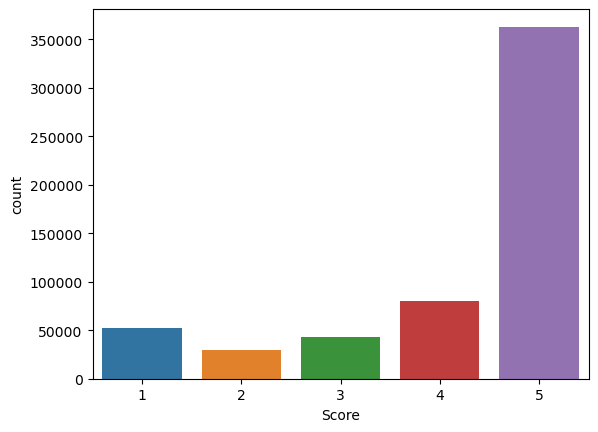

In [40]:
# Plot the distribution of Score
sns.countplot(x="Score", data=reviews_data)

<Axes: xlabel='HelpfulnessNumerator', ylabel='count'>

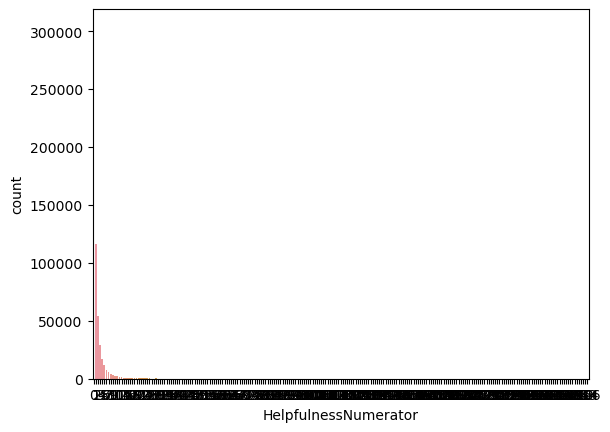

In [41]:
# Plot the distribution of HelpfulnessNumerator
sns.countplot(x="HelpfulnessNumerator", data=reviews_data)

<Axes: >

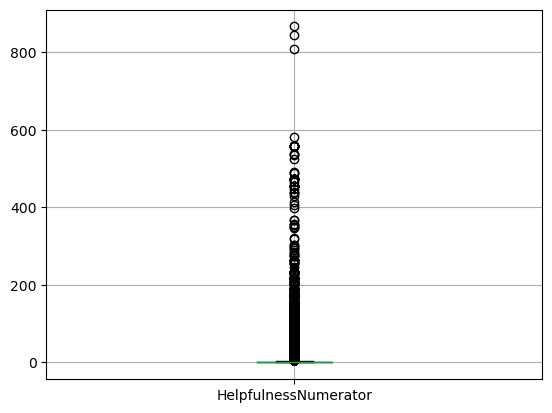

In [42]:
reviews_data.boxplot('HelpfulnessNumerator')

<Axes: xlabel='HelpfulnessDenominator', ylabel='count'>

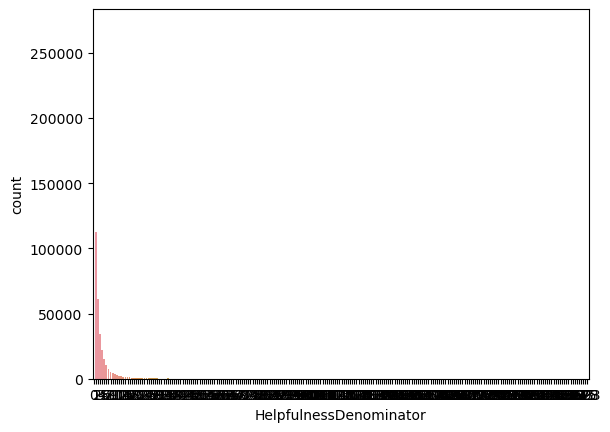

In [43]:
# Plot the distribution of HelpfulnessDenominator
sns.countplot(x="HelpfulnessDenominator", data=reviews_data)

<Axes: xlabel='HelpfulnessDenominator'>

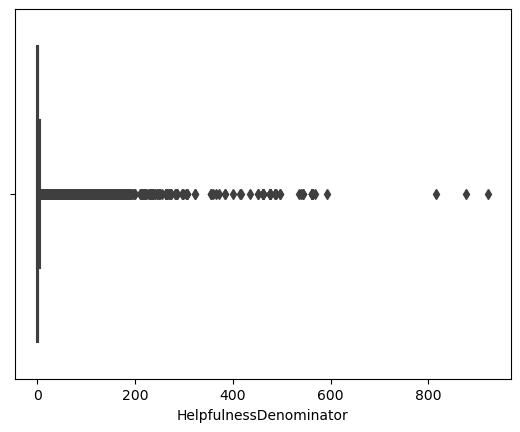

In [44]:
sns.boxplot(x="HelpfulnessDenominator", data=reviews_data)

In [47]:
# HelpfulnessDenominator should be greater than or equal to HelpfulnessNumerator. Remove those that do not satisfy this condition 
reviews_data = reviews_data[reviews_data["HelpfulnessNumerator"] <= reviews_data["HelpfulnessDenominator"]]

In [48]:
# Recheck the count
reviews_data.shape

(568452, 11)

In [49]:
# Check the datatypes of the columns
reviews_data.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
IsDuplicate                 bool
dtype: object

In [50]:
# Convert the Time column into datetime format
reviews_data['Time'] = pd.to_datetime(reviews_data['Time'], unit='s')

In [51]:
# Inspect the Time column values
reviews_data['Time'].head()

0   2011-04-27
1   2012-09-07
2   2008-08-18
3   2011-06-13
4   2012-10-21
Name: Time, dtype: datetime64[ns]

In [52]:
# Create a Month column from the Time data
reviews_data['Month'] = reviews_data['Time'].dt.month

# Create a Year column from the Time data
reviews_data['Year'] = reviews_data['Time'].dt.year

# Create a YearMonth column from the Time data
reviews_data['YearMonth'] = reviews_data['Time'].dt.to_period('M')  # This creates a period for each month of each year


c:\Users\sophia.bouchama\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sophia.bouchama\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


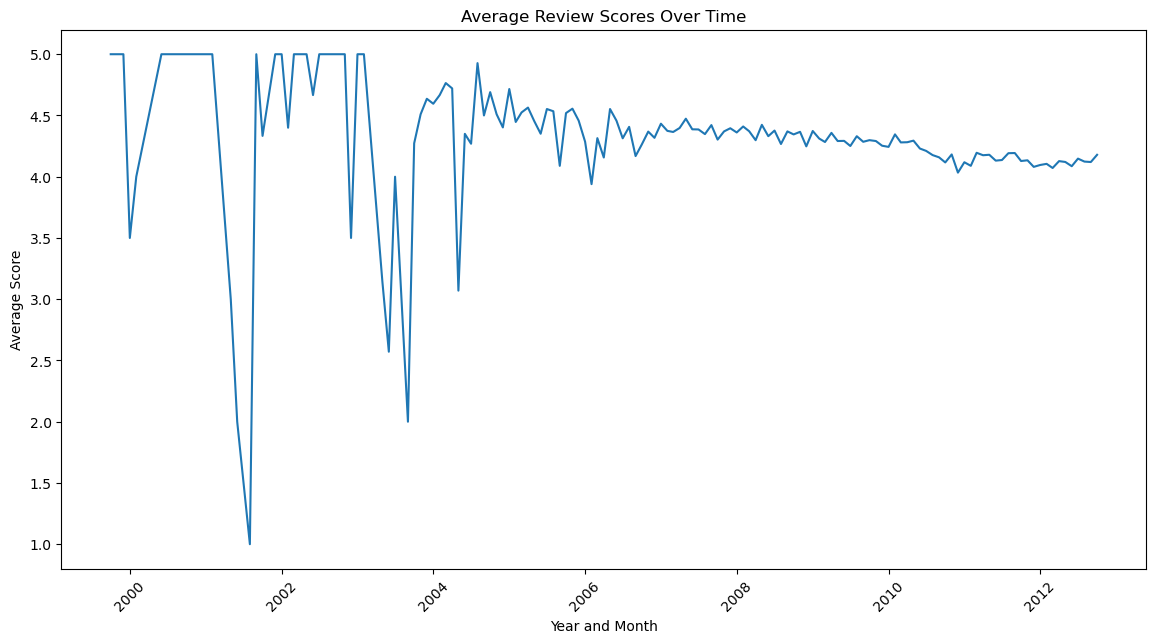

In [57]:
# Plot the Average Review Scores Over Time
average_scores = reviews_data.groupby('YearMonth')['Score'].mean().reset_index()
average_scores['YearMonth'] = average_scores['YearMonth'].dt.to_timestamp()

# Now plotting with Seaborn should work
plt.figure(figsize=(14, 7))
sns.lineplot(data=average_scores, x='YearMonth', y='Score')
plt.xticks(rotation=45)
plt.title('Average Review Scores Over Time')
plt.xlabel('Year and Month')
plt.ylabel('Average Score')
plt.show()

c:\Users\sophia.bouchama\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sophia.bouchama\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


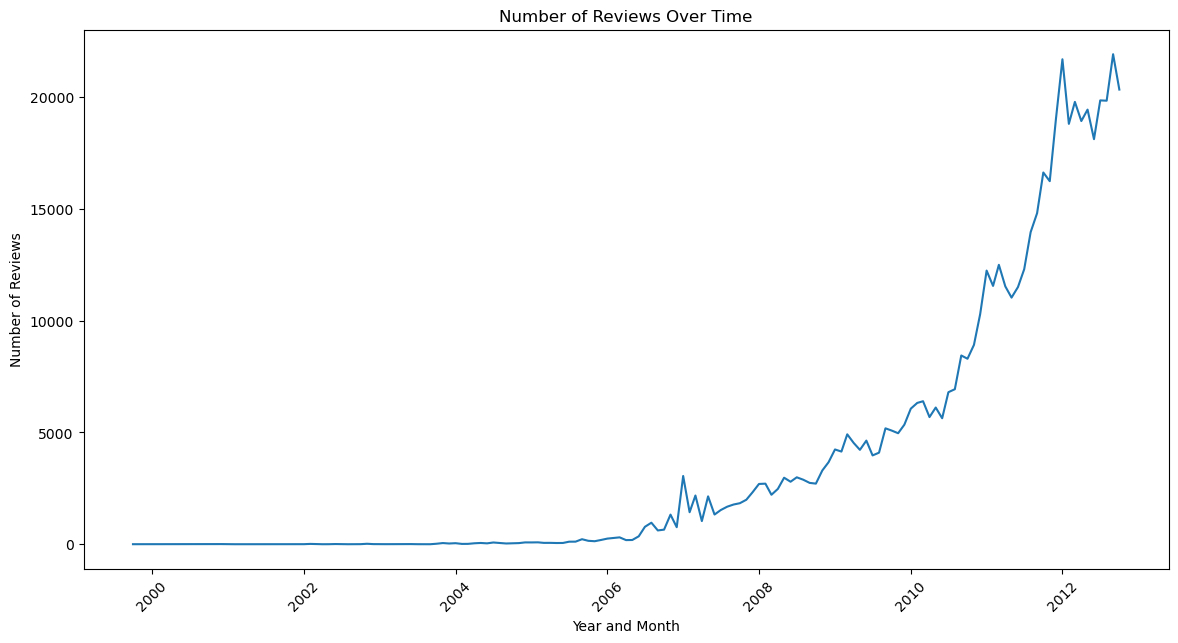

In [58]:
# Plot the Number of Reviews Over Time
review_counts = reviews_data.groupby('YearMonth').size().reset_index(name='ReviewCount')
review_counts['YearMonth'] = review_counts['YearMonth'].dt.to_timestamp()

# Plotting with Seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=review_counts, x='YearMonth', y='ReviewCount')
plt.xticks(rotation=45)
plt.title('Number of Reviews Over Time')
plt.xlabel('Year and Month')
plt.ylabel('Number of Reviews')
plt.show()



In [61]:
# Create columns for Positive, Negative and Neutral Reviews based on Score
reviews_data['PositiveReviews'] = reviews_data['Score'] > 3
reviews_data['NegativeReviews'] = reviews_data['Score'] < 3
reviews_data['NeutralReviews'] = reviews_data['Score'] == 3

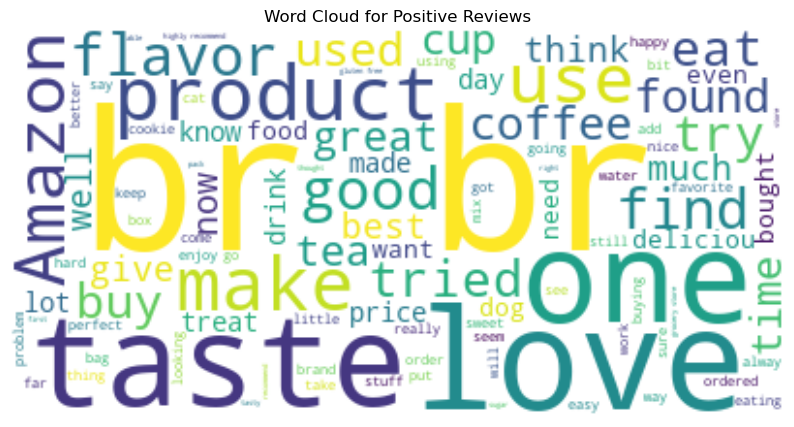

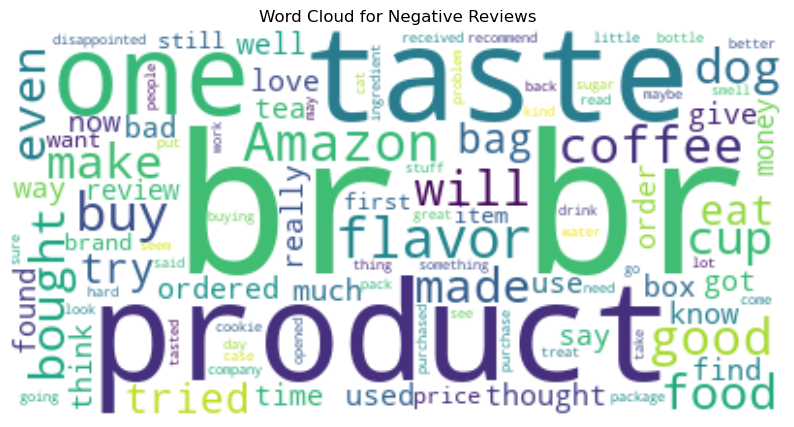

In [63]:
# Generate a wordcloud for positive and negative reviews

# Filter the reviews based on the boolean columns and join them into a single string for word cloud generation.
positive_reviews_text = " ".join(reviews_data[reviews_data['PositiveReviews']]['Text'])
negative_reviews_text = " ".join(reviews_data[reviews_data['NegativeReviews']]['Text'])

# Generate a word cloud image for positive reviews.
wordcloud_pos = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(positive_reviews_text)

# Display the generated image for positive reviews.
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Generate a word cloud image for negative reviews.
wordcloud_neg = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(negative_reviews_text)

# Display the generated image for negative reviews.
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Negative Reviews')
plt.show()


c:\Users\sophia.bouchama\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


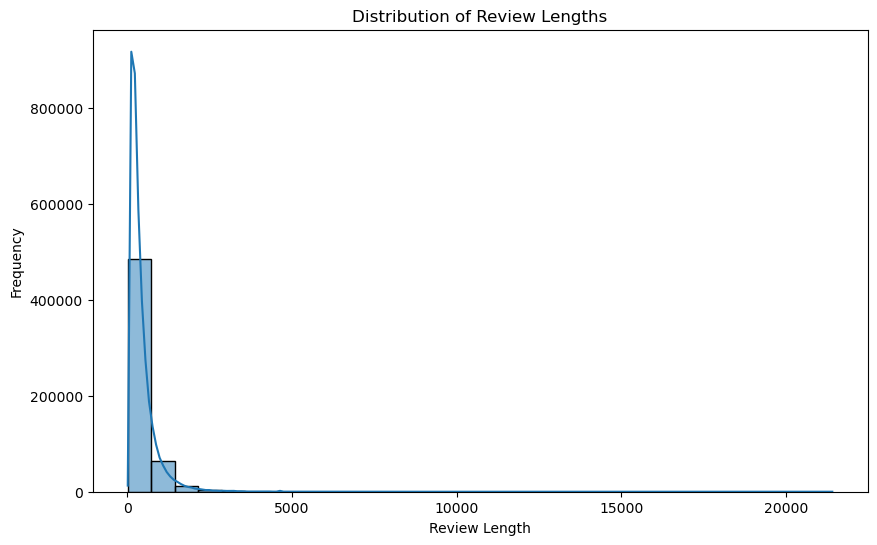

In [43]:
# Calculate review lengths
reviews_data['ReviewLength'] = reviews_data['Text'].apply(len)

# Histogram for Review Lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=reviews_data, x='ReviewLength', bins=30, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()



In [121]:
# Create a preprocessing function with optional steps
def preprocessing(sentence, lowercasing=True, remove_numbers=True, remove_punctuation=True, tokenize=True, remove_stopwords=True, lemmatize=True):

    # Removing whitespaces
    sentence = sentence.strip()

    # Lowercasing
    if lowercasing:
        sentence = sentence.lower()

    # Removing numbers
    if remove_numbers:
        sentence = ''.join(char for char in sentence if not char.isdigit())

    # Removing punctuation
    if remove_punctuation:
        for punctuation in string.punctuation:
            sentence = sentence.replace(punctuation, '')

    # Tokenizing
    if tokenize:    
        sentence = word_tokenize(sentence)

    # Removing stopwords
    if remove_stopwords and tokenize:
        stop_words = set(stopwords.words('english'))
        sentence = [word for word in sentence if word not in stop_words]

    # Lemmatizing
    if lemmatize and tokenize:
        lemmatizer = WordNetLemmatizer()
        lemmatized = [lemmatizer.lemmatize(word) for word in sentence]
        sentence = " ".join(lemmatized)

    return sentence   

In [123]:
reviews_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,bought several vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,product arrived labeled jumbo salted peanutsth...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",confection around century light pillowy citrus...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,looking secret ingredient robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,great taffy great price wide assortment yummy ...
